# Recurrent Neural Networks

## Univariate Time Series Regression

This notebook demonstrates how to forecast the S&P 500 index using a Recurrent Neural Network.

## Run inside docker container for GPU acceleration

See [tensorflow guide](https://www.tensorflow.org/install/docker) and more detailed [instructions](https://blog.sicara.com/tensorflow-gpu-opencv-jupyter-docker-10705b6cd1d)

`docker run -it -p 8889:8888 -v /path/to/machine-learning-for-trading/18_recurrent_neural_nets:/rnn --name tensorflow tensorflow/tensorflow:latest-gpu-py3 bash`

Inside docker container: 
`jupyter notebook --ip 0.0.0.0 --no-browser --allow-root`

## Imports & Settings

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web
from datetime import datetime, date
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import minmax_scale
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM
import keras

Using TensorFlow backend.


In [2]:
sns.set_style('whitegrid')
np.random.seed(42)

## Get Data

We obtain data for 2010-2018 from the Federal Reserve Bank’s Data Service [FRED](https://fred.stlouisfed.org/) using the [pandas_datareader](https://pandas-datareader.readthedocs.io/) library in introduced in [Chapter 2 on Market and Fundamental Data](../02_market_and_fundamental_data).

In [3]:
sp500 = web.DataReader('SP500', 'fred', start='2010', end='2019').dropna()
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2264 entries, 2010-01-04 to 2018-12-31
Data columns (total 1 columns):
SP500    2264 non-null float64
dtypes: float64(1)
memory usage: 35.4 KB


## Preprocessing

In [4]:
sp500_scaled = sp500.apply(minmax_scale)
sp500_scaled.describe()

,SP500
count,2264.000000
mean,0.437175
std,0.272843
min,0.000000
25%,0.172811
50%,0.462480
75%,0.600596
max,1.000000


## Generating recurrent sequences from our time series

Our time series is a sequence of numbers indexed by time:

$$x_{0},x_{1},x_{2},...,x_{T}$$

where $\{x_t\}$ is the numerical value in period $t$ and  $T$ is the total length of the series. 

To apply a RNN for regression of classification, we use a sliding window to construct a rolling set of input/output pairs for our model to learn from as animated below.

<img src="images/timeseries_windowing.gif" width=600 height=600/>

We will generate sequences of 63 trading days, approximately three months, and use a single LSTM layer with 20 hidden units to predict the index value one timestep ahead. 
The input to every LSTM layer must have three dimensions, namely:
- **Samples**: One sequence is one sample. A batch contains one or more samples.
- **Time Steps**: One time step is one point of observation in the sample.
- **Features**: One feature is one observation at a time step.

Our S&P 500 sample has 2,264 observations or time steps. We will create overlapping sequences using a window of 63 observations each.
For a simpler window of size T = 5, we obtain input-output pairs as shown in the following table:

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline  {\langle x_1,x_2,x_3,x_4,x_5\rangle} & { x_6} \\
\ {\langle x_{2},x_{3},x_{4},x_{5},x_{6} \rangle } & {x_{7} } \\
  {\vdots} & {\vdots}\\
 { \langle x_{T-5},x_{T-4},x_{T-3},x_{T-2},x_{T-1} \rangle } &  {x_{T}}
\end{array}$$

Generally speaking, for window size S, the relationship takes the form 

$$x_t = f( x_{t-1}, x_{t-2}, ..., x_{t-S}) \quad\forall t=S, S+1, ..., T$$

Each of the $T-S$ lagged input sequence or vector is of length S with a corresponding scalar output.

We can use the function create_univariate_rnn_data() to stack sequences selected using a rolling windows:

In [8]:
def create_univariate_rnn_data(data, window_size):
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    n = data.shape[0]
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

We apply this function to the rescaled stock index for a window_size=63 to obtain a two-dimensional dataset of shape number of samples x number of timesteps:

In [9]:
window_size = 63

In [10]:
X, y = create_univariate_rnn_data(sp500_scaled, window_size=window_size)

In [11]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
DATE,,,,,,,,,,,,,,,,,,,,,
2010-04-06,0.057862,0.059712,0.060037,0.062421,0.064145,0.065193,0.059554,0.064512,0.065969,0.059455,...,0.075061,0.079443,0.076062,0.075020,0.075470,0.078945,0.078971,0.076959,0.081502,0.086397
2010-04-07,0.059712,0.060037,0.062421,0.064145,0.065193,0.059554,0.064512,0.065969,0.059455,0.066897,...,0.079443,0.076062,0.075020,0.075470,0.078945,0.078971,0.076959,0.081502,0.086397,0.087445
2010-04-08,0.060037,0.062421,0.064145,0.065193,0.059554,0.064512,0.065969,0.059455,0.066897,0.060508,...,0.076062,0.075020,0.075470,0.078945,0.078971,0.076959,0.081502,0.086397,0.087445,0.083782
2010-04-09,0.062421,0.064145,0.065193,0.059554,0.064512,0.065969,0.059455,0.066897,0.060508,0.049209,...,0.075020,0.075470,0.078945,0.078971,0.076959,0.081502,0.086397,0.087445,0.083782,0.085873
2010-04-12,0.064145,0.065193,0.059554,0.064512,0.065969,0.059455,0.066897,0.060508,0.049209,0.036255,...,0.075470,0.078945,0.078971,0.076959,0.081502,0.086397,0.087445,0.083782,0.085873,0.090029


In [12]:
y.head()

,SP500
DATE,
2010-04-06,0.087445
2010-04-07,0.083782
2010-04-08,0.085873
2010-04-09,0.090029
2010-04-12,0.091134


In [13]:
X.shape

(2201, 63)

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2201 entries, 2010-04-06 to 2018-12-31
Data columns (total 63 columns):
0     2201 non-null float64
1     2201 non-null float64
2     2201 non-null float64
3     2201 non-null float64
4     2201 non-null float64
5     2201 non-null float64
6     2201 non-null float64
7     2201 non-null float64
8     2201 non-null float64
9     2201 non-null float64
10    2201 non-null float64
11    2201 non-null float64
12    2201 non-null float64
13    2201 non-null float64
14    2201 non-null float64
15    2201 non-null float64
16    2201 non-null float64
17    2201 non-null float64
18    2201 non-null float64
19    2201 non-null float64
20    2201 non-null float64
21    2201 non-null float64
22    2201 non-null float64
23    2201 non-null float64
24    2201 non-null float64
25    2201 non-null float64
26    2201 non-null float64
27    2201 non-null float64
28    2201 non-null float64
29    2201 non-null float64
30    2201 non-null float64
31    2

## Train-test split

To respect the time series nature of the data, we set aside the data at the end of the sample as hold-out or test set. More specifically, we'll use the data for 2018.

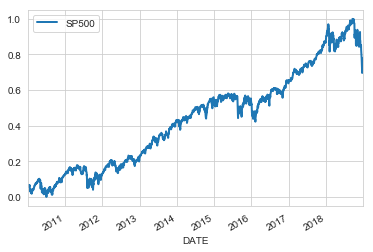

In [15]:
sp500_scaled.plot(lw=2);

In [16]:
X_train = X[:'2017'].values.reshape(-1, window_size, 1)
y_train = y[:'2017']

# keep the last year for testing
X_test = X['2018'].values.reshape(-1, window_size, 1)
y_test = y['2018']

In [17]:
n_obs, window_size, n_features = X_train.shape

In [18]:
y_train.shape

(1950, 1)

## Keras LSTM Layer

Keras has several built-in RNN layers with various configuration options described in detail in the [documentation](https://keras.io/layers/recurrent/).

In [ ]:
LSTM(units, 
      activation='tanh', 
      recurrent_activation='hard_sigmoid', 
      use_bias=True,
      kernel_initializer='glorot_uniform', 
      recurrent_initializer='orthogonal', 
      bias_initializer='zeros',
      unit_forget_bias=True, 
      kernel_regularizer=None, 
      recurrent_regularizer=None, 
      bias_regularizer=None,
      activity_regularizer=None, 
      kernel_constraint=None, 
      recurrent_constraint=None, 
      bias_constraint=None,
      dropout=0.0, 
      recurrent_dropout=0.0, 
      implementation=1, 
      return_sequences=False, 
      return_state=False,
      go_backwards=False, 
      stateful=False, 
      unroll=False)

##  Define the Model Architecture

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 20 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used (remember: we are performing regression here)

This can be constructed using just a few lines - see e.g., the [general Keras documentation](https://keras.io/getting-started/sequential-model-guide/) and the [LTSM documentation in particular](https://keras.io/layers/recurrent/) for examples of how to quickly use Keras to build neural network models.  Make sure you are initializing your optimizer given the [keras-recommended approach for RNNs](https://keras.io/optimizers/) 

In [19]:
rnn = Sequential([
    LSTM(units=20, 
         input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

Instructions for updating:
Colocations handled automatically by placer.


The summary shows that the model has 1,781 parameters:

In [20]:
rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 20)                1760      
_________________________________________________________________
Output (Dense)               (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


## Train the Model

We train the model using the RMSProp optimizer recommended for RNN with default settings and compile the model with mean squared error for this regression problem:

In [21]:
optimizer = keras.optimizers.RMSprop(lr=0.001,
                                     rho=0.9,
                                     epsilon=1e-08,
                                     decay=0.0)

In [22]:
rnn.compile(loss='mean_squared_error', optimizer=optimizer)

In [23]:
rnn_path = 'models/sp500.lstm5.weights.best.hdf5'
checkpointer = ModelCheckpoint(filepath=rnn_path,
                              monitor='val_loss',
                              save_best_only=True,
                              save_weights_only=True,
                              period=5)

We define an EarlyStopping callback and train the model for 500 episodes. 

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=25,
                              restore_best_weights=True)

In [25]:
result = rnn.fit(X_train,
                 y_train,
                 epochs=500,
                 batch_size=20,
                 validation_data=(X_test, y_test),
                 callbacks=[checkpointer, early_stopping],
                 verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 1950 samples, validate on 251 samples
Epoch 1/500
1950/1950 [==============================] - 4s 2ms/step - loss: 0.0259 - val_loss: 0.0022
Epoch 2/500
1950/1950 [==============================] - 3s 1ms/step - loss: 6.4320e-04 - val_loss: 0.0014
Epoch 3/500
1950/1950 [==============================] - 3s 1ms/step - loss: 4.0963e-04 - val_loss: 0.0043
Epoch 4/500
1950/1950 [==============================] - 3s 1ms/step - loss: 3.6222e-04 - val_loss: 8.3634e-04
Epoch 5/500
1950/1950 [==============================] - 3s 1ms/step - loss: 3.2014e-04 - val_loss: 0.0017
Epoch 6/500
1950/1950 [==============================] - 3s 1ms/step - loss: 2.8507e-04 - val_loss: 6.9610e-04
Epoch 7/500
1950/1950 [==============================] - 3s 1ms/step - loss: 2.7760e-04 - val_loss: 6.6384e-04
Epoch 8/500
1950/1950 [==============================] - 3s 1ms/step - loss: 2.5975e-04 - val_loss: 6.3310e-04
Epoch 9/500
1950/1950 [==============

Epoch 144/500
1950/1950 [==============================] - 3s 1ms/step - loss: 7.7013e-05 - val_loss: 6.2298e-04
Epoch 145/500
1950/1950 [==============================] - 3s 1ms/step - loss: 7.8551e-05 - val_loss: 6.0778e-04
Epoch 146/500
1950/1950 [==============================] - 3s 2ms/step - loss: 7.8303e-05 - val_loss: 6.7426e-04
Epoch 147/500
1950/1950 [==============================] - 3s 1ms/step - loss: 7.5538e-05 - val_loss: 2.2505e-04
Epoch 148/500
1950/1950 [==============================] - 3s 1ms/step - loss: 8.2132e-05 - val_loss: 2.3028e-04
Epoch 149/500
1950/1950 [==============================] - 3s 1ms/step - loss: 7.6928e-05 - val_loss: 2.2649e-04
Epoch 150/500
1950/1950 [==============================] - 3s 1ms/step - loss: 7.8825e-05 - val_loss: 2.6291e-04
Epoch 151/500
1950/1950 [==============================] - 3s 1ms/step - loss: 7.9428e-05 - val_loss: 2.3031e-04
Epoch 152/500
1950/1950 [==============================] - 3s 1ms/step - loss: 7.7981e-05 - val_

Training stops after 177 epochs and we reload the weights for the best model:

In [26]:
rnn.load_weights(rnn_path)

The loss history shows how the model’s validation error converges to an error level that illustrates the noise inherent in predicting stock prices:

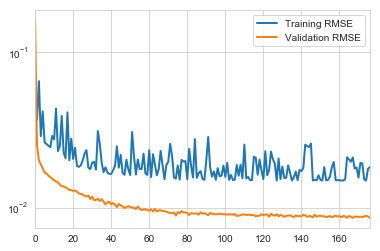

In [27]:
loss_history = pd.DataFrame(result.history).pow(.5)
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.plot(logy=True, lw=2);

## Evaluate model performance

The following charts illustrate the out-of-sample forecast performance that generally track the index development in 2018 well with a test RMSE of 0.015 on the rescaled price series. The test IC is 95.85%. 

In [28]:
def eval_result():
    test_predict = pd.Series(rnn.predict(X_test).squeeze(), index=y_test.index)
    train_predict = pd.Series(rnn.predict(X_train).squeeze(), index=y_train.index)
    rmse = np.sqrt(mean_squared_error(test_predict, y_test))
    return test_predict, train_predict, rmse

In [29]:
test_predict, train_predict, rmse = eval_result()

In [30]:
predictions = (test_predict.to_frame('prediction').assign(data='test')
               .append(train_predict.to_frame('prediction').assign(data='train')))
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2201 entries, 2018-01-02 to 2017-12-29
Data columns (total 2 columns):
prediction    2201 non-null float32
data          2201 non-null object
dtypes: float32(1), object(1)
memory usage: 43.0+ KB


In [31]:
results = sp500_scaled.join(predictions).dropna()
results.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2201 entries, 2010-04-06 to 2018-12-31
Data columns (total 3 columns):
SP500         2201 non-null float64
prediction    2201 non-null float32
data          2201 non-null object
dtypes: float32(1), float64(1), object(1)
memory usage: 60.2+ KB


In [32]:
corr = {}
for run, df in results.groupby('data'):
    corr[run] = df.SP500.corr(df.prediction)

In [33]:
sp500_scaled['Train Prediction'] = pd.Series(train_predict.squeeze(), index=y_train.index)
sp500_scaled['Test Prediction'] = pd.Series(test_predict.squeeze(), index=y_test.index)

In [34]:
training_error = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
testing_error = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print('Training Error: {:.4f} | Test Error: {:.4f}'.format(training_error, testing_error))

Training Error: 0.0076 | Test Error: 0.0150


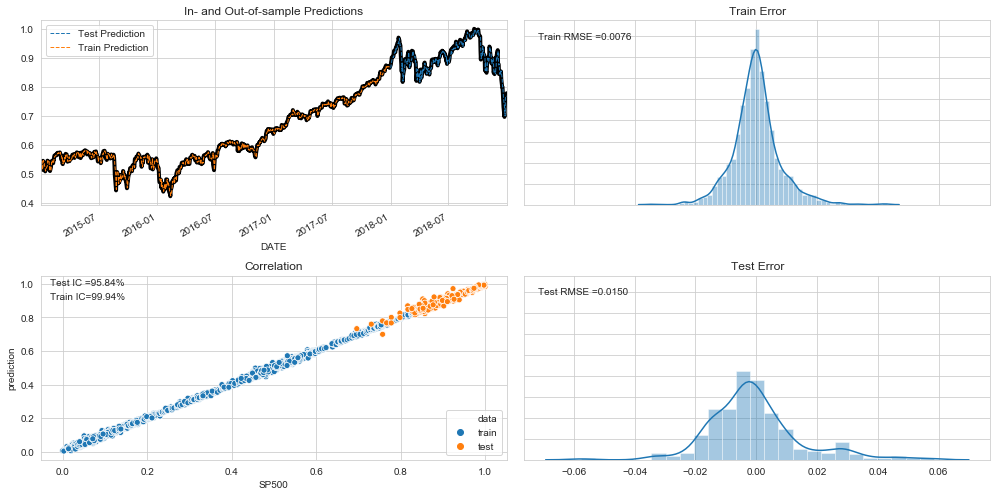

In [35]:
fig=plt.figure(figsize=(14,7))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)

sp500_scaled.loc['2015':, 'SP500'].plot(lw=4, ax=ax1, c='k')
sp500_scaled.loc['2015':, ['Test Prediction', 'Train Prediction']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')

sns.scatterplot(x='SP500', y='prediction', data=results, hue='data', ax=ax3)
ax3.text(x=.02, y=.95, s='Test IC ={:.2%}'.format(corr['test']), transform=ax3.transAxes)
ax3.text(x=.02, y=.87, s='Train IC={:.2%}'.format(corr['train']), transform=ax3.transAxes)
ax3.set_title('Correlation')
ax3.legend(loc='lower right')

sns.distplot(train_predict.squeeze()-y_train.squeeze(), ax=ax2)
ax2.set_title('Train Error')
ax2.text(x=.03, y=.9, s='Train RMSE ={:.4f}'.format(training_error), transform=ax2.transAxes)
sns.distplot(test_predict.squeeze()-y_test.squeeze(), ax=ax4)
ax4.set_title('Test Error')
ax4.text(x=.03, y=.9, s='Test RMSE ={:.4f}'.format(testing_error), transform=ax4.transAxes)

fig.tight_layout()
fig.savefig('images/rnn_sp500_regression', dpi=300);